## Import and old part


In [4]:
# Import general libraries
import cv2
import numpy as np

In [6]:
# Load the image data: loaded as a 2D numpy array
# dtype='>f4': 32 bit little-endian single-precision float
from astropy.io import fits

img_path = 'dataset/hst_skycell-p0047x09y19_acs_wfc_f658n_all_drc.fits'
raw_img = fits.getdata(img_path)

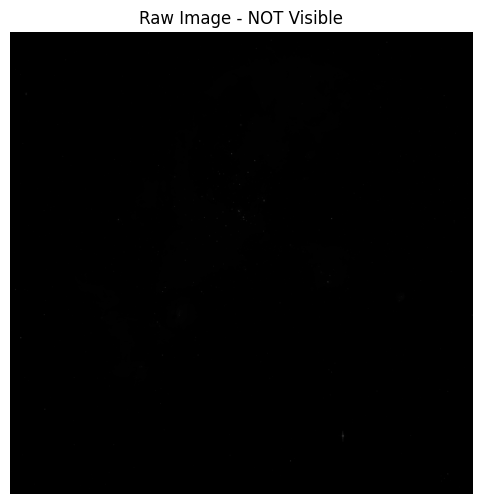

In [7]:
# Simple image plot
# Just to show that a transormation is needed to display the image
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))
plt.imshow(raw_img, cmap='gray')
plt.title('Raw Image - NOT Visible')
plt.axis('off')
plt.show()

In [9]:
# Using auto_stretch library to visualize the image
from auto_stretch import apply_stretch

stretched_img = apply_stretch(raw_img)

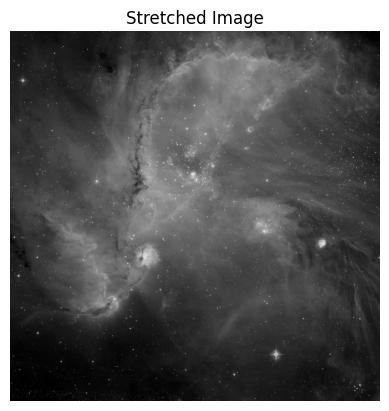

In [10]:
# Plot stretched image
plt.imshow(stretched_img, cmap='gray')
plt.title('Stretched Image')
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Arcsinh Stretched Image')

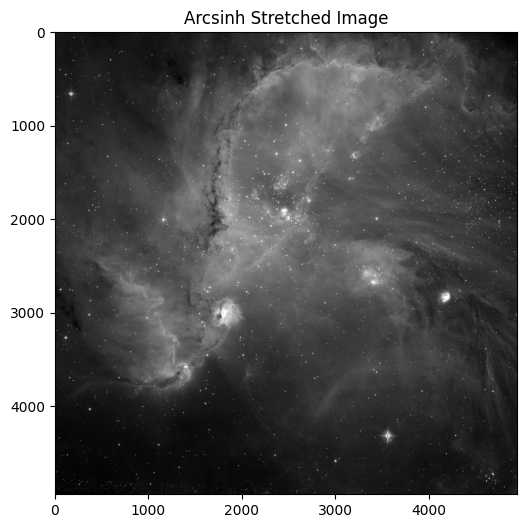

In [6]:
# arcsinh stretch

def arcsinh_stretch(image, beta, min_percent=0.1, max_percent=99.9):
    """
    Apply arcsinh stretch to the image.
    """
    # Calculate the percentiles for stretching
    p_min = np.percentile(image, min_percent)
    p_max = np.percentile(image, max_percent)

    # Normalize the image to the range [0, 1]
    norm_image = (image - p_min) / (p_max - p_min)
    norm_image = np.clip(norm_image, 0, 1)

    # Apply arcsinh stretch
    stretched_image = np.arcsinh(norm_image * beta) / np.arcsinh(beta)

    return stretched_image


stretched_img_arcsinh = arcsinh_stretch(raw_img, 10)
plt.figure(figsize=(12, 6))
plt.imshow(stretched_img_arcsinh, cmap='gray')
plt.title('Arcsinh Stretched Image')

In [14]:
def float32_to_uint8(float_img):
    """
    Convert a float32 image to uint8 format.
    
    Parameters:
    - float_img: np.float32 array, input image
    
    Returns:
    - np.uint8 array, output image with values in range 0-255
    """
    # Check the current range of the image
    min_val = float_img.min()
    max_val = float_img.max()
    
    # Method 1: Simple scaling (for images already in 0-1 range)
    if 0 <= min_val and max_val <= 1:
        uint8_img = (float_img * 255).clip(0, 255).astype(np.uint8)

        
    
    # Method 2: Full normalization (for images with arbitrary ranges)
    else:
        # Normalize to 0-1 range first
        normalized_img = (float_img - min_val) / (max_val - min_val)
        # Then scale to 0-255
        uint8_img = (normalized_img * 255).clip(0, 255).astype(np.uint8)
    
    return uint8_img



In [15]:
def diff_img(image0, image1):
    diff = cv2.absdiff(image0, image1)
    return diff

## New part

In [16]:
stretched_img_uint = float32_to_uint8(stretched_img)
cv2.imwrite('./output_images/original_image.png', stretched_img_uint)


True

In [20]:
def use_blob_detector(name, original_image, params, smoothing_params = None):
    """
    Use a blob detector to find and mask stars in an image.
    
    Parameters:
    - name: str, name of the image for saving output
    - original_image: np.array, the original image
    - params: cv2.SimpleBlobDetector_Params, parameters for the blob detector
    - smooth: int, smoothing factor for Gaussian blur
    
    Returns:
    - mask: np.array, binary mask of detected stars
    """
    
    # Convert to grayscale if not already
    if len(original_image.shape) == 3:
        img_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = original_image

    # Apply Gaussian blur to reduce noise
    if smoothing_params is not None:
        blur = cv2.GaussianBlur(img_gray, (smoothing_params["kernel_size"], smoothing_params["kernel_size"]), smoothing_params["sigma"])
    else:
        blur = img_gray

    # Create the blob detector with the specified parameters
    detector = cv2.SimpleBlobDetector_create(params)

    # Detect blobs (stars)
    keypoints = detector.detect(blur)

    img_con_punti = cv2.drawKeypoints(
    original_image, keypoints, np.array([]), (0, 0, 255),
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
            )
    
    cv2.imwrite(f'./output_images/{name}_blob_keypoints.png', img_con_punti)

    # Create a mask for the detected blobs
    mask = np.zeros(img_gray.shape, dtype=np.uint8)
    
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])       # coordinates of the center
        r = int(kp.size / 2)                      # estimated radius of the blob
        cv2.circle(mask, (x, y), r, 255, thickness=-1)  # draw blob in the mask

    cv2.imwrite(f'./output_images/{name}_mask.png', mask)

    return mask

Super small stars

In [ ]:
# Imposta i parametri del detector
params = cv2.SimpleBlobDetector_Params()

params.minThreshold = 40
params.maxThreshold = 255
params.thresholdStep = 5

# Filtro per area (modifica questi se rileva troppo)
params.filterByArea = True
params.minArea = 3     # evita pixel singoli o rumore
params.maxArea = 30   # evita blob grandi come galassie

# Filtro per circolarità
params.filterByCircularity = False
params.minCircularity = 0.8  # più vicino a 1 = più circolare

params.filterByConvexity = False
params.minConvexity = 0.8  # più vicino a 1 = più convesso
params.filterByInertia = False      # per la simmetria, si potrebbe usare

# Cerca solo blob chiari su sfondo scuro
params.filterByColor = True
params.blobColor = 255
smoothing_params = {
    "kernel_size": 3,  # Size of the Gaussian kernel
    "sigma": 0.5       # Standard deviation for Gaussian kernel
}

mask1 = use_blob_detector('r1_xs', stretched_img_uint, params, smoothing_params)

In [ ]:
# Imposta i parametri del detector
params = cv2.SimpleBlobDetector_Params()

params.minThreshold = 30
params.maxThreshold = 255
params.thresholdStep = 5

# Filtro per area (modifica questi se rileva troppo)
params.filterByArea = True
params.minArea = 3     # evita pixel singoli o rumore
params.maxArea = 20   # evita blob grandi come galassie

# Filtro per circolarità
params.filterByCircularity = False
params.minCircularity = 0.8  # più vicino a 1 = più circolare

params.filterByConvexity = False
params.minConvexity = 0.8  # più vicino a 1 = più convesso
params.filterByInertia = False      # per la simmetria, si potrebbe usare

# Cerca solo blob chiari su sfondo scuro
params.filterByColor = True
params.blobColor = 255
smoothing_params = None

mask1_xs = use_blob_detector('m1_xs', stretched_img_uint, params, smoothing_params)

small stars

In [31]:
# Imposta i parametri del detector
params = cv2.SimpleBlobDetector_Params()

params.minThreshold = 70
params.maxThreshold = 255
params.thresholdStep = 5

# Filtro per area (modifica questi se rileva troppo)
params.filterByArea = True
params.minArea = 20     # evita pixel singoli o rumore
params.maxArea = 100   # evita blob grandi come galassie

# Filtro per circolarità
params.filterByCircularity = True
params.minCircularity = 0.8  # più vicino a 1 = più circolare

params.filterByConvexity = True
params.minConvexity = 0.8  # più vicino a 1 = più convesso
params.filterByInertia = False      # per la simmetria, si potrebbe usare

# Cerca solo blob chiari su sfondo scuro
params.filterByColor = True
params.blobColor = 255
smoothing_params = {
    "kernel_size": 3,  # Size of the Gaussian kernel
    "sigma": 0.5       # Standard deviation for Gaussian kernel
}

mask2_sm = use_blob_detector('m2_s', stretched_img_uint, params, smoothing_params)

Medium

In [36]:
# Imposta i parametri del detector
params = cv2.SimpleBlobDetector_Params()

params.minThreshold = 50
params.maxThreshold = 255
params.thresholdStep = 5

# Filtro per area (modifica questi se rileva troppo)
params.filterByArea = True
params.minArea = 70     # evita pixel singoli o rumore
params.maxArea = 500   # evita blob grandi come galassie

# Filtro per circolarità
params.filterByCircularity = True
params.minCircularity = 0.85  # più vicino a 1 = più circolare

params.filterByConvexity = True
params.minConvexity = 0.85  # più vicino a 1 = più convesso
params.filterByInertia = False      # per la simmetria, si potrebbe usare

# Cerca solo blob chiari su sfondo scuro
params.filterByColor = True
params.blobColor = 255
smoothing_params = {
    "kernel_size": 5,  # Size of the Gaussian kernel
    "sigma": 0       # Standard deviation for Gaussian kernel
}

mask3_m = use_blob_detector('m3_m', stretched_img_uint, params, smoothing_params)

Large stars

In [45]:
# Imposta i parametri del detector
params = cv2.SimpleBlobDetector_Params()

params.minThreshold = 100
params.maxThreshold = 255
params.thresholdStep = 5

# Filtro per area (modifica questi se rileva troppo)
params.filterByArea = True
params.minArea = 400     
params.maxArea = 3000  

# Filtro per circolarità
params.filterByCircularity = True
params.minCircularity = 0.8  # più vicino a 1 = più circolare

params.filterByConvexity = True
params.minConvexity = 0.8  # più vicino a 1 = più convesso
params.filterByInertia = True
params.minInertiaRatio = 0.8  # più vicino a 1 = più simmetrico

# Cerca solo blob chiari su sfondo scuro
params.filterByColor = True
params.blobColor = 255
smoothing_params = {
    "kernel_size": 7,  # Size of the Gaussian kernel
    "sigma": 1.5       # Standard deviation for Gaussian kernel
}

mask4_l = use_blob_detector('m4_l', stretched_img_uint, params, smoothing_params)

In [46]:
merged_mask = cv2.bitwise_or(mask1_xs, mask2_sm)
merged_mask = cv2.bitwise_or(merged_mask, mask3_m)
merged_mask = cv2.bitwise_or(merged_mask, mask4_l)
cv2.imwrite('./output_images/merged_mask.png', merged_mask)
stretched_img_wo_stars = stretched_img_uint.copy()
stretched_img_wo_stars[merged_mask == 255] = 0
cv2.imwrite('./output_images/stretched_wo_stars_m1234.png', stretched_img_wo_stars)

True

In [58]:
kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask1_dilated = cv2.dilate(mask1_xs, kernel1, iterations=2)
mask2_dilated = cv2.dilate(mask2_sm, kernel1, iterations=3)
mask3_dilated = cv2.dilate(mask3_m, kernel1, iterations=4)
mask4_dilated = cv2.dilate(mask4_l, kernel1, iterations=4)

merged_mask_dilated = cv2.bitwise_or(mask1_dilated, mask2_dilated)
merged_mask_dilated = cv2.bitwise_or(merged_mask_dilated, mask3_dilated)
merged_mask_dilated = cv2.bitwise_or(merged_mask_dilated, mask4_dilated)
cv2.imwrite('./output_images/merged_mask_dilated.png', merged_mask_dilated)
stretched_img_wo_stars_dilated = stretched_img_uint.copy()
stretched_img_wo_stars_dilated[merged_mask_dilated == 255] = 0
cv2.imwrite('./output_images/stretched_wo_stars_dilated_1234.png', stretched_img_wo_stars_dilated)


True

In [59]:
# Perform inpainting to remove stars using the merged mask
inpainted_image = cv2.inpaint(stretched_img_uint, merged_mask_dilated, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

# Save the inpainted image
cv2.imwrite('./output_images/i2_inpainted_image.png', inpainted_image)

True